In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2

from camera import Camera
import structure
import processor
import features

In [2]:
img1 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0289.JPG')
img2 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0288.JPG')
print("Bilder geladen")

Bilder geladen
Punkte gefunden


In [3]:
pts1, pts2 = features.find_correspondence_points(img1, img2)
print("Punkte gefunden")

Punkte gefunden


In [4]:
points1 = processor.cart2hom(pts1)
points2 = processor.cart2hom(pts2)

/tmp/ipykernel_22083/2309110751.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


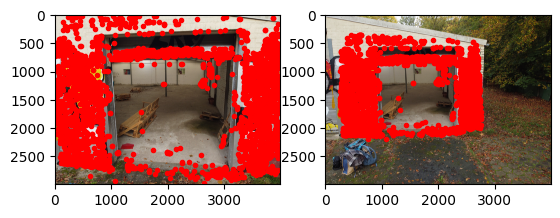

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].autoscale_view('tight')
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].plot(points1[0], points1[1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].plot(points2[0], points2[1], 'r.')
fig.show()

In [7]:
height, width, ch = img1.shape
intrinsic = np.array([  # for dino
    [3030.65, 0, width / 2-6],
    [0, 3030.65, height / 2+17],
    [0, 0, 1]])
intrinsic

array([[3.03065e+03, 0.00000e+00, 1.99400e+03],
       [0.00000e+00, 3.03065e+03, 1.51700e+03],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]])

In [8]:
# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
points1n = np.dot(np.linalg.inv(intrinsic), points1)
points2n = np.dot(np.linalg.inv(intrinsic), points2)
E = structure.compute_essential_normalized(points1n, points2n)
print('Computed essential matrix:', (-E / E[0][1]))

Computed essential matrix: [[-0.03209267 -1.         -0.23936483]
 [ 0.95771216 -0.01071871  0.00662765]
 [ 0.2710667   0.19223359  0.04855587]]


In [46]:
E2,mask = cv2.findEssentialMat(pts1.T,pts2.T, intrinsic, method=cv2.FM_LMEDS)
retval, R, t, mask = cv2.recoverPose(
    E2, pts1.T, pts2.T, intrinsic)
R,t

(array([[ 9.78853780e-01,  3.79934203e-02, -2.01001935e-01],
        [-3.73740765e-02,  9.99277684e-01,  6.87665529e-03],
        [ 2.01118015e-01,  7.81021652e-04,  9.79566707e-01]]),
 array([[ 0.00704604],
        [-0.18750506],
        [ 0.98223836]]))

In [10]:

# Given we are at camera 1, calculate the parameters for camera 2
# Using the essential matrix returns 4 possible camera paramters
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2s = structure.compute_P_from_essential(E)
P2s

[array([[-0.98442522, -0.04629197,  0.16959967,  0.18489437],
        [-0.04134381, -0.876694  , -0.47926853, -0.26190074],
        [ 0.17087329, -0.47881593,  0.86112579,  0.94721807]]),
 array([[-0.98442522, -0.04629197,  0.16959967, -0.18489437],
        [-0.04134381, -0.876694  , -0.47926853,  0.26190074],
        [ 0.17087329, -0.47881593,  0.86112579, -0.94721807]]),
 array([[ 0.98097419, -0.03968222,  0.19003938,  0.18489437],
        [ 0.04623216,  0.99847544, -0.03015603, -0.26190074],
        [-0.18855299,  0.03836822,  0.98131323,  0.94721807]]),
 array([[ 0.98097419, -0.03968222,  0.19003938, -0.18489437],
        [ 0.04623216,  0.99847544, -0.03015603,  0.26190074],
        [-0.18855299,  0.03836822,  0.98131323, -0.94721807]])]

In [11]:
ind = -1
for i, P2 in enumerate(P2s):
    # Find the correct camera parameters
    d1 = structure.reconstruct_one_point(
        points1n[:, 0], points2n[:, 0], P1, P2)

    # Convert P2 from camera view to world view
    P2_homogenous = np.linalg.inv(np.vstack([P2, [0, 0, 0, 1]]))
    d2 = P2_homogenous[:3, :4] @ d1

    if d1[2] > 0 and d2[2] > 0:
        ind = i

P2 = np.linalg.inv(np.vstack([P2s[ind], [0, 0, 0, 1]]))[:3, :4]
print(P2)

[[ 0.98097419  0.04623216 -0.18855299 -0.00933244]
 [-0.03968222  0.99847544  0.03836822 -0.23249541]
 [ 0.19003938 -0.03015603  0.98131323  0.97255272]]


In [44]:
retval, R, t, mask = cv2.recoverPose(E2,pts1.T,pts2.T,intrinsic)
np.linalg.inv(np.vstack([np.hstack([R,t]),[0,0,0,1]]))

array([[ 0.98052439, -0.03625619,  0.19302179, -0.19087841],
       [ 0.03717197,  0.99930825, -0.00112382,  0.19120618],
       [-0.19284752,  0.00827694,  0.98119383, -0.96281132],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
#tripoints3d = structure.reconstruct_points(points1n, points2n, P1, P2)
tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)

In [ ]:
fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.add_subplot(projection='3d')
ax.plot(tripoints3d[0], tripoints3d[1], tripoints3d[2], 'b.')
ax.plot([0], [0], [0], 'r.')
ax.plot(-P2[0, 3], -P2[1, 3], -P2[2, 3], 'r.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()